# Testing notebook for ISED workflow and functions

## 1. Load all functions

## 2. Load simulation data with opted preprocessing manner 

## 3. Determine latent_dim

## 4. Train ISEDModel on training time series 

## 5. Attain embedding dynamics and decoded dynamics

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ISED_learner import ISED
from sklearn import preprocessing



In [2]:
data_file = '../ISED_learner/data/Simulation_data/Xs.pkl' ## Replace with your own data, accepting .pkl or .npy files

#### Preprocessing: normalization + subsequencing 
processor = ISED.DataProcessor(filepath=data_file, alpha=0.5)## alpha = 0, 0.5, 1 === [0,1,2]
x_train, x_test, x = processor.load_and_preprocess_data(method = 'buffering') ## Choices: 'Buffering'; 'Appending'; 'Sliding'
x = x[:x_train.shape[0]]
x_test.shape, x_train.shape, x.shape

((500, 125, 100), (500, 125, 100), (500, 100))

In [3]:
## ISED instantation 

latent_dim = 20

model = ISED.ISEDModel(
    input_dim=100, 
    seq_length=125, 
    latent_dim=latent_dim, 
    batch_size=50, 
    epochs=300,
    encoder_layers=[(50, 'relu'), (latent_dim, 'relu')],
    rnn_layers=[(30, 'gru'), (latent_dim, 'gru')],
    decoder_layers=[(latent_dim, 'relu'), (30, 'relu')],
    optimizer='adam', verbose = 0
)

In [4]:
#### ISED training on training dataset
#### Depending on your machine, on 10-core cpu-based machine, for t = 500, D = 100 ==> d = 20, roughly 10-15 mins
model.fit(x_train[:400],x[:400])


In [5]:
#### Apply trained ISED on test data to examine its learned trajectories and decoded dynamics as well
#### Importantly, standardize the length of test set for future comparison
from sklearn import preprocessing

length = (len(x_test)//32)*32
length = 320
z_y = model.transform(x_test[:length])
encoded_data = preprocessing.MinMaxScaler().fit_transform(z_y)
decoded_data =  preprocessing.MinMaxScaler().fit_transform(model.decode(encoded_data))

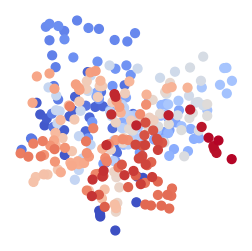

In [6]:
### Low-dimensional visualization 

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
        
pca_emb = pca.fit_transform(encoded_data)

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(3,3), dpi = 100)
ax = fig.add_subplot(111)
time_points = np.arange(encoded_data.shape[0])
sc = ax.scatter(pca_emb[:,0],
                pca_emb[:,1],
           c=time_points,
           cmap='coolwarm', s=40)

ax.grid(False)
ax.set_axis_off()